In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
df = pd.read_csv("KDDTrain.csv")
test_df = pd.read_csv("KDDTest.csv")

In [5]:

columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns


In [6]:
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack


In [7]:
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']


attack_labels = ['Normal','DoS','Probe','Privilege','Access']

In [8]:
def map_attack(attack):
    if attack in dos_attacks:
        attack_type = 1
    elif attack in probe_attacks:
        attack_type = 2
    elif attack in privilege_attacks:
        attack_type = 3
    elif attack in access_attacks:
        attack_type = 4
    else:
        attack_type = 0
    return attack_type

In [9]:
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map
test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map
df.head()

duration protocol_type  service flag  src_bytes  dst_bytes  land  \
0         0           udp    other   SF        146          0     0   
1         0           tcp  private   S0          0          0     0   
2         0           tcp     http   SF        232       8153     0   
3         0           tcp     http   SF        199        420     0   
4         0           tcp  private  REJ          0          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_src_port_rate  \
0               0       0    0  ...                         0.88   
1               0       0    0  ...                         0.00   
2               0       0    0  ...                         0.03   
3               0       0    0  ...                         0.00   
4               0       0    0  ...                         0.00   

   dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0                         0.00                  0.00   
1                         0.00                  1.00   
2                         0.04                  0.03   
3                         0.00                  0.00   
4                         0.00                  0.00   

   dst_host_srv_serror_rate  dst_host_rerror_rate  dst_host_srv_rerror_rate  \
0                      0.00                   0.0                      0.00   
1                      1.00                   0.0                      0.00   
2                      0.01                   0.0                      0.01   
3                      0.00                   0.0                      0.00   
4                      0.00                   1.0                      1.00   

    attack  level  attack_flag  attack_map  
0   normal     15            0           0  
1  neptune     19            1           1  
2   normal     21            0           0  
3   normal     21            0           0  
4  neptune     21            1           1  

[5 rows x 45 columns]

Understanding relationship and causality between attack and protocol

In [10]:
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)

In [11]:
def bake_pies(data_list,labels):
    list_length = len(data_list)
    
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    for count, data_set in enumerate(data_list): 
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        axs[count].set_title(labels[count])
    return axs   

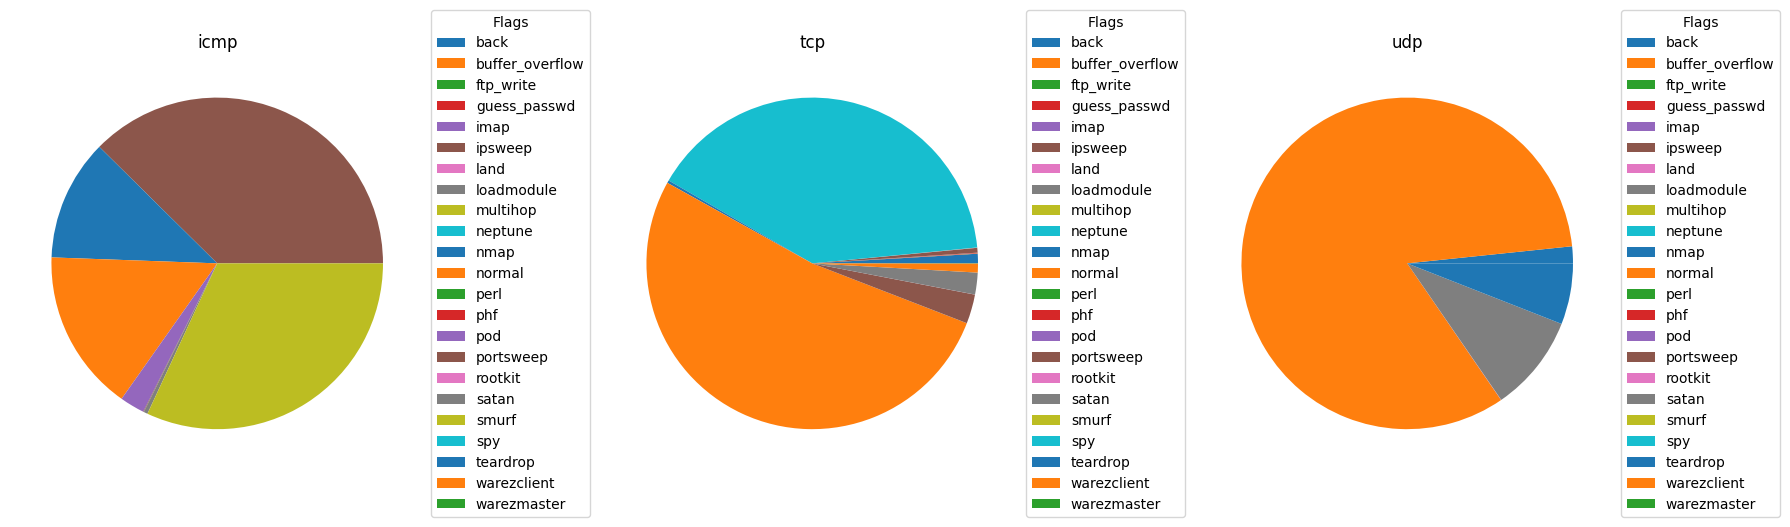

In [12]:
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

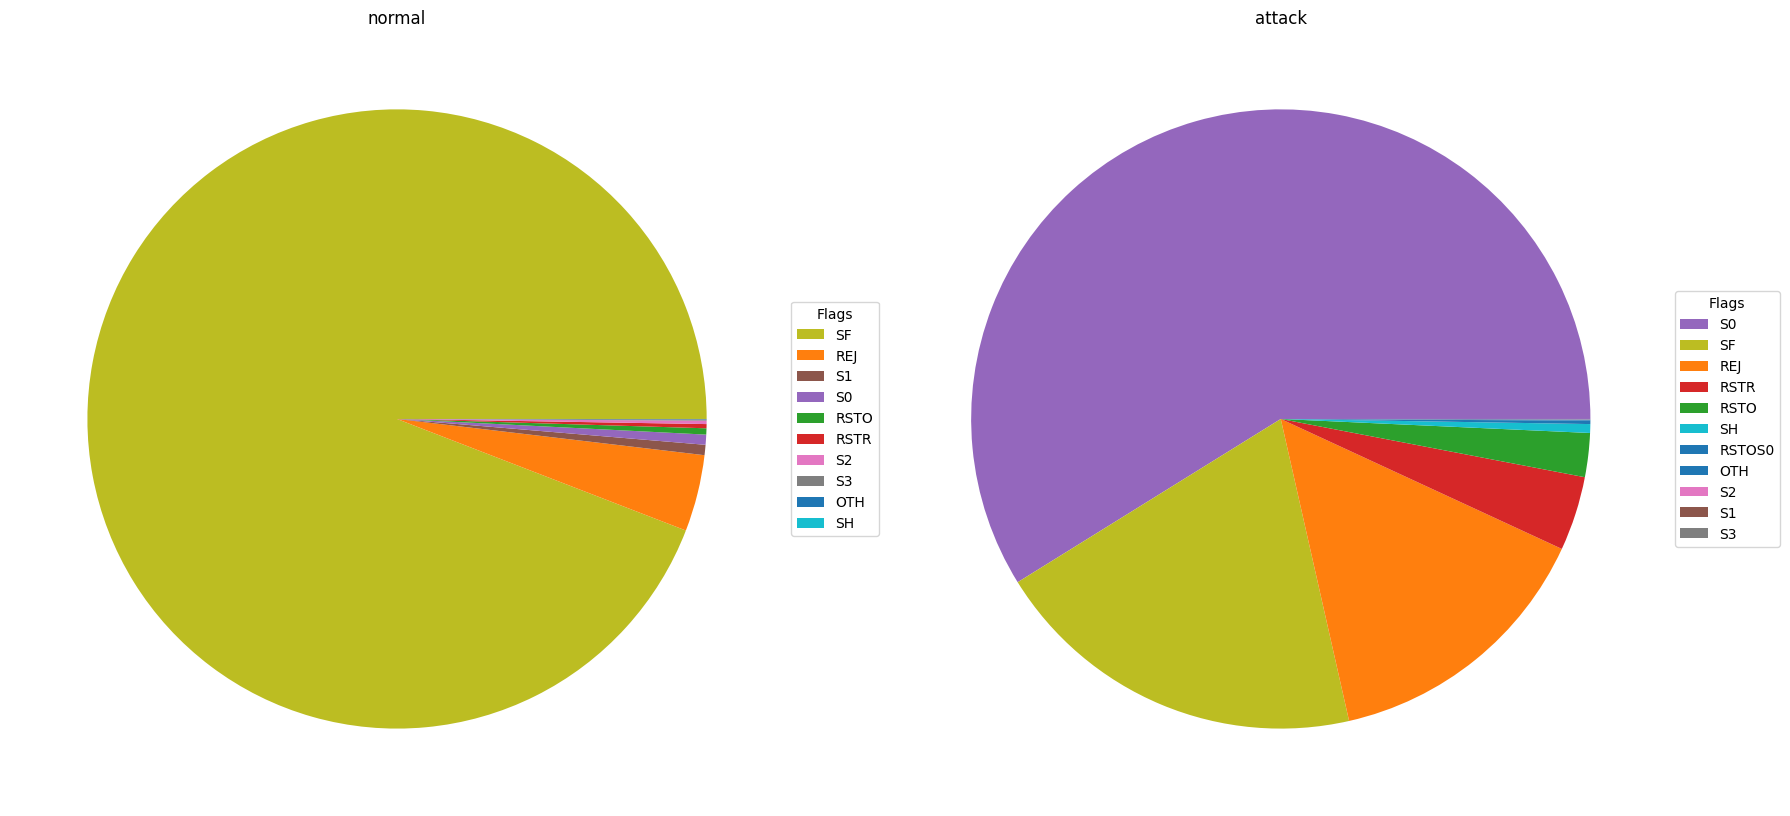

In [13]:

normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()
flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])        
plt.show()

In [14]:
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))
diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)
column_order = encoded.columns.to_list()
test_encoded_temp = test_encoded_base.join(diff_df)
test_final = test_encoded_temp[column_order].fillna(0)
numeric_features = ['duration', 'src_bytes', 'dst_bytes']
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

In [15]:
binary_y = df['attack_flag']
multi_y = df['attack_map']
test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.6)

In [16]:
models = [
    LogisticRegression(max_iter=250),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    GaussianNB()  
]

model_comps = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, binary_train_X, binary_train_y, scoring='accuracy')
    for count, accuracy in enumerate(accuracies):
        model_comps.append((model_name, count, accuracy))

/home/krishna/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/krishna/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [17]:
recalls = np.array([0.87238, 0.97812, 0.90601, 0.67129, 0.46921])
recalls

array([0.87238, 0.97812, 0.90601, 0.67129, 0.46921])

Box Plot of Accuracy Scores


<Axes: >

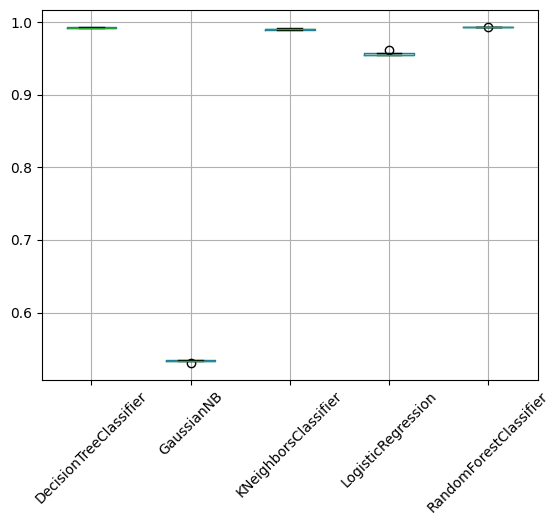

In [20]:
result_df = pd.DataFrame(model_comps, columns=['model_name', 'count', 'accuracy'])
print("Box Plot of Accuracy Scores")
result_df.pivot(index='count',columns='model_name',values='accuracy').boxplot(rot=45)

In [21]:
result_df = result_df.groupby('model_name').mean()
result_df

count  accuracy
model_name                             
DecisionTreeClassifier    2.0  0.992597
GaussianNB                2.0  0.533143
KNeighborsClassifier      2.0  0.990216
LogisticRegression        2.0  0.956498
RandomForestClassifier    2.0  0.993272

In [22]:
models = np.array(['RandomForest', 'DTree', 'KNN', 'LogReg', 'GaussianNB'])
accuracies =result_df['accuracy'].values
accuracies= sorted(accuracies, reverse=True)
print("Models: ",models)
print("Accuracies: ",accuracies)
print("Recalls: ",recalls)

Models:  ['RandomForest' 'DTree' 'KNN' 'LogReg' 'GaussianNB']
Accuracies:  [np.float64(0.9932722088342072), np.float64(0.9925974323960712), np.float64(0.9902159622149773), np.float64(0.9564975566289993), np.float64(0.5331428098895501)]
Recalls:  [0.87238 0.97812 0.90601 0.67129 0.46921]


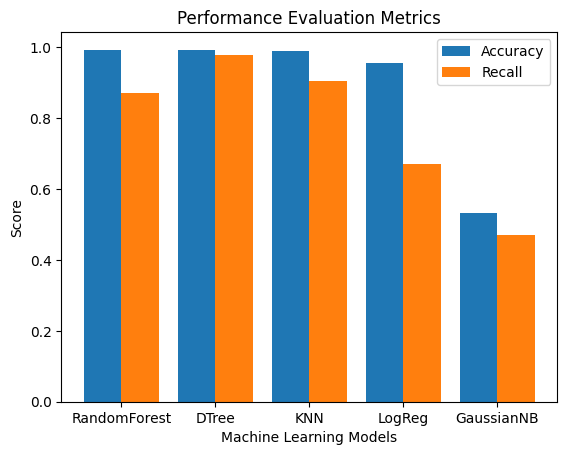

In [23]:
X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, accuracies, 0.4, label = 'Accuracy')
plt.bar(X_axis + 0.2, recalls, 0.4, label = 'Recall')
  
plt.xticks(X_axis, models)
plt.xlabel("Machine Learning Models")
plt.ylabel("Score")
plt.title("Performance Evaluation Metrics")
plt.legend()
plt.show()

In [24]:
#Decision Tree
clf = DecisionTreeClassifier() #max_depth=10
clf = clf.fit(binary_train_X, binary_train_y)
clf_predictions = clf.predict(binary_val_X) 
train_acc = clf.score(binary_train_X, binary_train_y)
base_clf_score = accuracy_score(clf_predictions,binary_val_y)
print("Training accuracy is:", train_acc*100 )
print("Testing accuracy is:", base_clf_score*100)

Training accuracy is: 99.43835833928713
Testing accuracy is: 99.29217823878069


In [25]:
#Decision Tree Performance Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score
Tree_f1 = f1_score(binary_val_y, clf_predictions, average="macro")
Tree_precision = precision_score(binary_val_y, clf_predictions, average="macro")
Tree_recall = recall_score(binary_val_y, clf_predictions, average="macro")
Tree_accuracy = accuracy_score(binary_val_y, clf_predictions)
cm_dtree = confusion_matrix(binary_val_y, clf_predictions)
print('Confusion Matrix: ')
print(cm_dtree)
print("Accuracy Score: ", Tree_f1)
print("Precision Score: ", Tree_precision)
print("Recall Score: ", Tree_recall)
print("F1 Score: ", Tree_accuracy)

Confusion Matrix: 
[[40132   338]
 [  197 34917]]
Accuracy Score:  0.9928879256452865
Precision Score:  0.9927639425405518
Recall Score:  0.9930189182668379
F1 Score:  0.9929217823878069


In [26]:
def add_predictions(data_set,predictions,y):
    prediction_series = pd.Series(predictions, index=y.index)

    predicted_vs_actual = data_set.assign(predicted=prediction_series)
    original_data = predicted_vs_actual.assign(actual=y).dropna()
    conf_matrix = confusion_matrix(original_data['actual'], 
                                   original_data['predicted'])
    
    # capture rows with failed predictions
    base_errors = original_data[original_data['actual'] != original_data['predicted']]
    
    # drop columns with no value
    non_zeros = base_errors.loc[:,(base_errors != 0).any(axis=0)]

    # identify the type of error
    false_positives = non_zeros.loc[non_zeros.actual==0]
    false_negatives = non_zeros.loc[non_zeros.actual==1]

    # put everything into an object
    prediction_data = {'data': original_data,
                       'confusion_matrix': conf_matrix,
                       'errors': base_errors,
                       'non_zeros': non_zeros,
                       'false_positives': false_positives,
                       'false_negatives': false_negatives}
    return prediction_data

<Axes: >

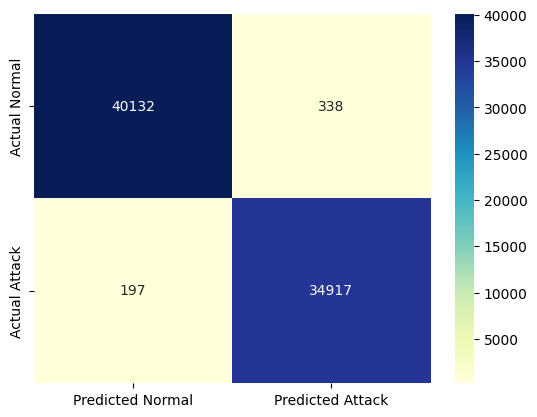

In [27]:
binary_prediction_data = add_predictions(df,
                                         clf_predictions,
                                         binary_val_y)

sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

In [28]:
binary_prediction_data['errors'].describe()

duration     src_bytes     dst_bytes        land  wrong_fragment  \
count    535.000000  5.350000e+02  5.350000e+02  535.000000           535.0   
mean     211.467290  1.300814e+06  2.451032e+06    0.009346             0.0   
std     2338.619468  2.997723e+07  5.663343e+07    0.096311             0.0   
min        0.000000  0.000000e+00  0.000000e+00    0.000000             0.0   
25%        0.000000  0.000000e+00  0.000000e+00    0.000000             0.0   
50%        0.000000  0.000000e+00  0.000000e+00    0.000000             0.0   
75%        0.000000  0.000000e+00  0.000000e+00    0.000000             0.0   
max    42338.000000  6.933756e+08  1.309937e+09    1.000000             0.0   

           urgent         hot  num_failed_logins   logged_in  num_compromised  \
count  535.000000  535.000000         535.000000  535.000000       535.000000   
mean     0.001869    0.102804           0.028037    0.093458         1.525234   
std      0.043234    0.775739           0.331209    0.291346        32.697954   
min      0.000000    0.000000           0.000000    0.000000         0.000000   
25%      0.000000    0.000000           0.000000    0.000000         0.000000   
50%      0.000000    0.000000           0.000000    0.000000         0.000000   
75%      0.000000    0.000000           0.000000    0.000000         0.000000   
max      1.000000   15.000000           5.000000    1.000000       756.000000   

       ...  dst_host_srv_diff_host_rate  dst_host_serror_rate  \
count  ...                   535.000000            535.000000   
mean   ...                     0.064131              0.096654   
std    ...                     0.197832              0.227944   
min    ...                     0.000000              0.000000   
25%    ...                     0.000000              0.000000   
50%    ...                     0.000000              0.000000   
75%    ...                     0.030000              0.040000   
max    ...                     1.000000              1.000000   

       dst_host_srv_serror_rate  dst_host_rerror_rate  \
count                535.000000            535.000000   
mean                   0.033944              0.317888   
std                    0.140602              0.445744   
min                    0.000000              0.000000   
25%                    0.000000              0.000000   
50%                    0.000000              0.000000   
75%                    0.010000              0.970000   
max                    1.000000              1.000000   

       dst_host_srv_rerror_rate       level  attack_flag  attack_map  \
count                535.000000  535.000000   535.000000  535.000000   
mean                   0.348841   15.106542     0.368224    0.601869   
std                    0.458776    5.655021     0.482774    0.962011   
min                    0.000000    0.000000     0.000000    0.000000   
25%                    0.000000   14.000000     0.000000    0.000000   
50%                    0.000000   18.000000     0.000000    0.000000   
75%                    1.000000   19.000000     1.000000    1.000000   
max                    1.000000   21.000000     1.000000    4.000000   

        predicted      actual  
count  535.000000  535.000000  
mean     0.631776    0.368224  
std      0.482774    0.482774  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      1.000000    0.000000  
75%      1.000000    1.000000  
max      1.000000    1.000000  

[8 rows x 43 columns]

In [29]:
binary_prediction_data['false_negatives']

duration protocol_type service  flag  src_bytes  dst_bytes  land  \
918            0           tcp    http   REJ          0          0     0   
1222           0           tcp    http   REJ          0          0     0   
1754           0           tcp    http   REJ          0          0     0   
2444           0           tcp     ftp  RSTO          0        133     0   
3172          98           tcp  telnet    SF        621       8356     0   
...          ...           ...     ...   ...        ...        ...   ...   
123846         2           tcp    time    SF          0          4     0   
124511         0           tcp    http   REJ          0          0     0   
124713         0           tcp    time    SF          0          4     0   
124787         0           tcp    http   REJ          0          0     0   
125392         0           tcp     X11   REJ          0          0     0   

        urgent  hot  num_failed_logins  ...  dst_host_serror_rate  \
918          0    0                  0  ...                   0.0   
1222         0    0                  0  ...                   0.0   
1754         0    0                  0  ...                   0.0   
2444         0    0                  0  ...                   0.0   
3172         1    1                  0  ...                   0.0   
...        ...  ...                ...  ...                   ...   
123846       0    0                  0  ...                   0.0   
124511       0    0                  0  ...                   0.0   
124713       0    0                  0  ...                   0.0   
124787       0    0                  0  ...                   0.0   
125392       0    0                  0  ...                   0.0   

        dst_host_srv_serror_rate  dst_host_rerror_rate  \
918                          0.0                  1.00   
1222                         0.0                  1.00   
1754                         0.0                  1.00   
2444                         0.0                  1.00   
3172                         0.0                  0.00   
...                          ...                   ...   
123846                       0.0                  0.89   
124511                       0.0                  0.93   
124713                       0.0                  0.94   
124787                       0.0                  1.00   
125392                       0.0                  0.01   

        dst_host_srv_rerror_rate   attack  level  attack_flag  attack_map  \
918                         1.00  neptune     18            1           1   
1222                        1.00  neptune     20            1           1   
1754                        1.00  neptune     20            1           1   
2444                        1.00  ipsweep      9            1           2   
3172                        0.00  rootkit      1            1           3   
...                          ...      ...    ...          ...         ...   
123846                      0.50  ipsweep      3            1           2   
124511                      0.01  ipsweep      6            1           2   
124713                      0.00  ipsweep      1            1           2   
124787                      1.00  neptune     20            1           1   
125392                      1.00    satan     16            1           2   

        predicted  actual  
918           0.0     1.0  
1222          0.0     1.0  
1754          0.0     1.0  
2444          0.0     1.0  
3172          0.0     1.0  
...           ...     ...  
123846        0.0     1.0  
124511        0.0     1.0  
124713        0.0     1.0  
124787        0.0     1.0  
125392        0.0     1.0  

[197 rows x 44 columns]

## Explainable AI with LIME

In [31]:
data = pd.read_csv("/home/krishna/Documents/BTP/KDDTrain.csv")
data.columns = columns
data.drop(['level'], axis=1, inplace=True)
data

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0              0           udp     other   SF        146          0     0   
1              0           tcp   private   S0          0          0     0   
2              0           tcp      http   SF        232       8153     0   
3              0           tcp      http   SF        199        420     0   
4              0           tcp   private  REJ          0          0     0   
...          ...           ...       ...  ...        ...        ...   ...   
125967         0           tcp   private   S0          0          0     0   
125968         8           udp   private   SF        105        145     0   
125969         0           tcp      smtp   SF       2231        384     0   
125970         0           tcp    klogin   S0          0          0     0   
125971         0           tcp  ftp_data   SF        151          0     0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0                    0       0    0  ...                   1   
1                    0       0    0  ...                  26   
2                    0       0    0  ...                 255   
3                    0       0    0  ...                 255   
4                    0       0    0  ...                  19   
...                ...     ...  ...  ...                 ...   
125967               0       0    0  ...                  25   
125968               0       0    0  ...                 244   
125969               0       0    0  ...                  30   
125970               0       0    0  ...                   8   
125971               0       0    0  ...                  77   

        dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                         0.00                    0.60   
1                         0.10                    0.05   
2                         1.00                    0.00   
3                         1.00                    0.00   
4                         0.07                    0.07   
...                        ...                     ...   
125967                    0.10                    0.06   
125968                    0.96                    0.01   
125969                    0.12                    0.06   
125970                    0.03                    0.05   
125971                    0.30                    0.03   

        dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                              0.88                         0.00   
1                              0.00                         0.00   
2                              0.03                         0.04   
3                              0.00                         0.00   
4                              0.00                         0.00   
...                             ...                          ...   
125967                         0.00                         0.00   
125968                         0.01                         0.00   
125969                         0.00                         0.00   
125970                         0.00                         0.00   
125971                         0.30                         0.00   

        dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                       0.00                      0.00                  0.00   
1                       1.00                      1.00                  0.00   
2                       0.03                      0.01                  0.00   
3                       0.00                      0.00                  0.00   
4                       0.00                      0.00                  1.00   
...                      ...                       ...                   ...   
125967                  1.00                      1.00                  0.00   
125968                  0.00                      0.00                  0.00   
125969                  0.72                      0.00                  0.01   


In [32]:
attacks = data['attack'].unique()
attacks

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [33]:
catCols = data.select_dtypes(include = "object").columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for feat in catCols:
    data[feat] = le.fit_transform(data[feat].astype(str))
data.head()

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0         0              2       44     9        146          0     0   
1         0              1       49     5          0          0     0   
2         0              1       24     9        232       8153     0   
3         0              1       24     9        199        420     0   
4         0              1       49     1          0          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   1   
1               0       0    0  ...                  26   
2               0       0    0  ...                 255   
3               0       0    0  ...                 255   
4               0       0    0  ...                  19   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.00                    0.60   
1                    0.10                    0.05   
2                    1.00                    0.00   
3                    1.00                    0.00   
4                    0.07                    0.07   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.88                         0.00   
1                         0.00                         0.00   
2                         0.03                         0.04   
3                         0.00                         0.00   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                   0.0   
1                  1.00                      1.00                   0.0   
2                  0.03                      0.01                   0.0   
3                  0.00                      0.00                   0.0   
4                  0.00                      0.00                   1.0   

   dst_host_srv_rerror_rate  attack  
0                      0.00      11  
1                      0.00       9  
2                      0.01      11  
3                      0.00      11  
4                      1.00       9  

[5 rows x 42 columns]

In [34]:
from sklearn.model_selection import train_test_split
x = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
y_test

62803     18
91686     18
60756     11
2663       9
90682     11
          ..
113425     9
19594     11
9534      11
122787     9
26185     10
Name: attack, Length: 25195, dtype: int64

In [36]:
model = DecisionTreeClassifier(random_state=18)
model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=18)

In [37]:
# Install lime
!pip install lime

In [38]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_train),
    feature_names=x_train.columns,
    class_names=attacks,
    mode='classification'
)

In [39]:
y_test.mode() 

0    11
Name: attack, dtype: int64

### LIME interpretation for different attacks in the test dataset


In [40]:
for i in range(1, 5):
    exp = explainer.explain_instance(data_row=x_train.iloc[i], 
                                     predict_fn=model.predict_proba)

    exp.show_in_notebook(show_table=True)

/home/krishna/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/krishna/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/krishna/.local/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

/home/krishna/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/krishna/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/krishna/.local/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

/home/krishna/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/krishna/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/krishna/.local/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

/home/krishna/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/krishna/.local/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/krishna/.local/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

## Explainable AI with SHAP

In [41]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement shap (from versions: none)
ERROR: No matching distribution found for shap

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [42]:
import shap
# Fit the SHAP explainer
explainer = shap.Explainer(model.predict, x_test)
# Calculate SHAP values
shap_values = explainer(x_test)

PermutationExplainer explainer: 25196it [06:44, 61.14it/s]                      


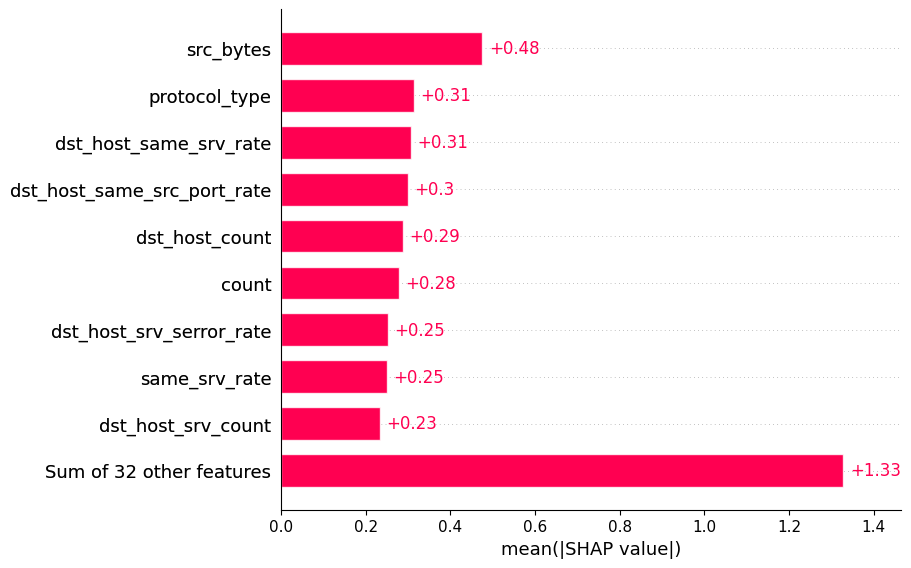

In [43]:
# Bar Plot
shap.plots.bar(shap_values)

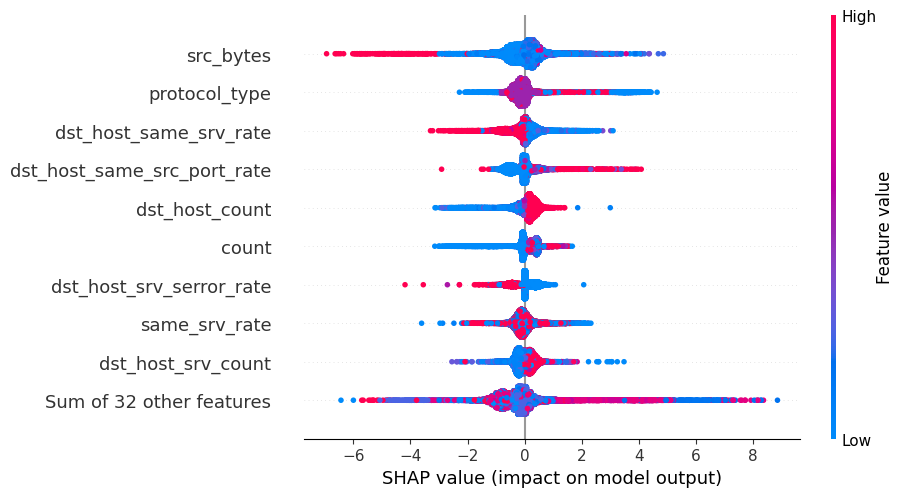

In [44]:
# Summary Plot (Beeswarm)
shap.plots.beeswarm(shap_values)

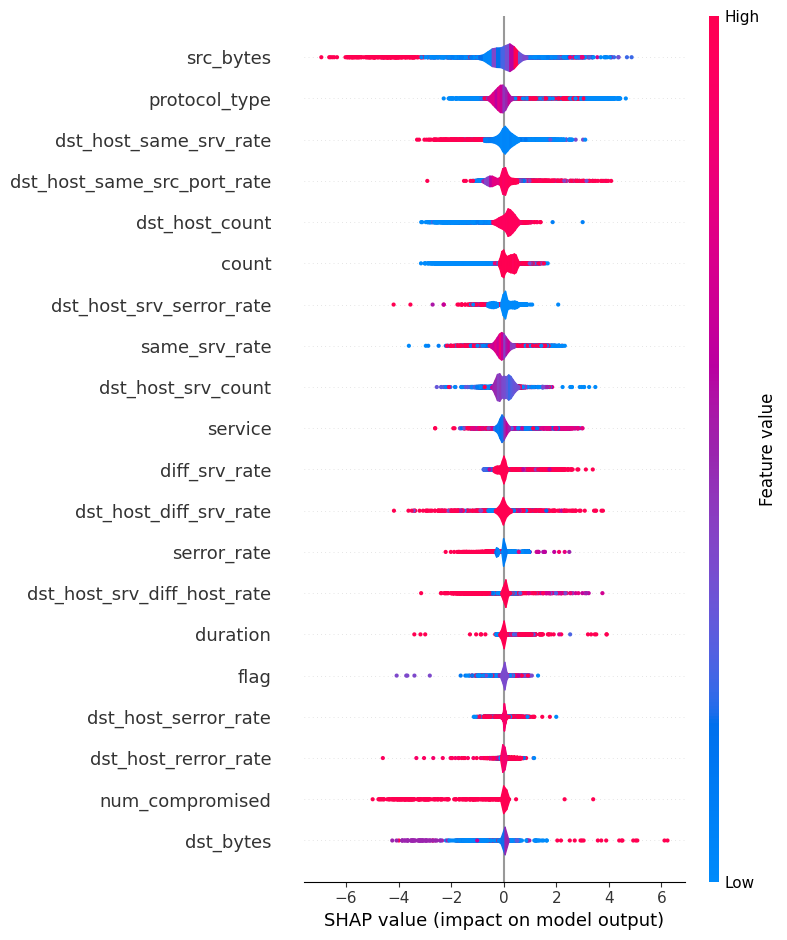

In [45]:
# Summary Plot (Violin)
shap.summary_plot(shap_values, plot_type='violin')

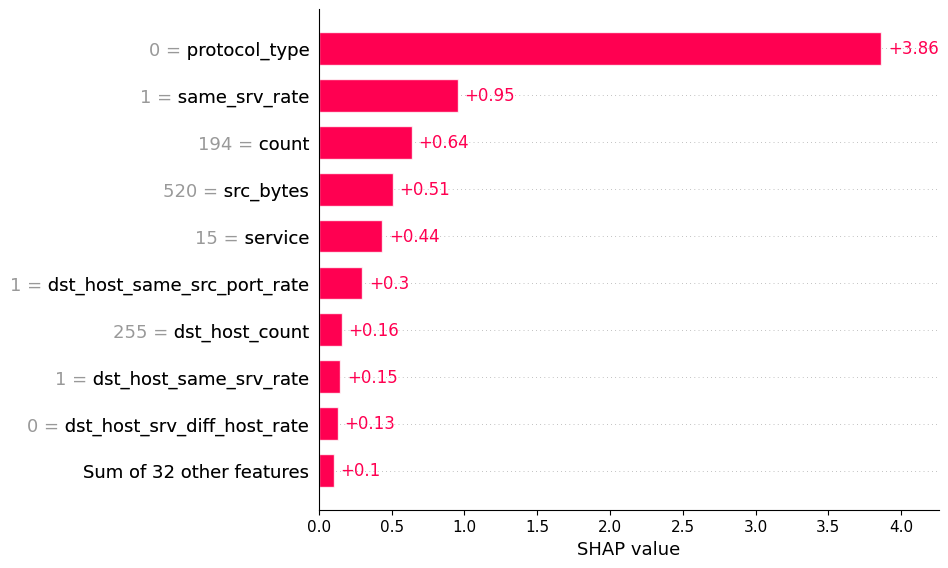

In [46]:
# Local Bar Plot
shap.plots.bar(shap_values[0])

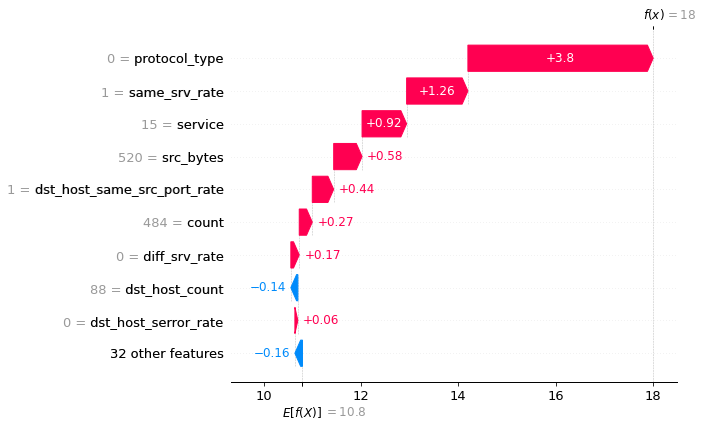

In [40]:
# Waterfall Plot
shap.plots.waterfall(shap_values[0])